# 1. Preprocessing and statistical analysis

@ Author       :     Michael(Ke Ma)
@ Supervisor   :     Angel Andrew
@ Created date :     01. 06. 2023
@ Project      :     Clustering Analysis of Nucleosomes Chaperones

Here are the meanings of some common variable in this scripts.
1. count:         Using the "count" variable to control the loop and check the progress of the loop.
2. file_name:     The name of the data to be read can be represented by an absolute path or a relative path, 
                  for example: r"D:\data.csv" or r".\data.csv"
3. save_path:     Path to save pictures and result data
4. feature_start: The final data dimension used for clustering is n*1000, 
                  and the first few columns of the general data are the
                  names of genes and other information. 
                  This parameter is used to cut the data by column, and the cut data can
                  be used as the input of cluster analysis.

# 1.1 Frequency and mapping data extract (Chapter 3.1.1 & 3.1.2)

In [ ]:
import os
import math

# Import third-party libraries
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
"""
In order to find the nucleosome file quickly,
I renamed the Roman numeral file name of the nucleosome to Arabic numerals.
This is a global variable of dictionary type, 
in which Roman numerals correspond to Arabic numerals one by one
"""

CHR = {
    "chrI":    1,
    "chrII":   2,
    "chrIII":  3,
    "chrIV":   4,
    "chrV":    5,
    "chrVI":   6,
    "chrVII":  7,
    "chrVIII": 8,
    "chrIX":   9,
    "chrX":    10,
    "chrXI":   11,
    "chrXII":  12,
    "chrXIII": 13,
    "chrXIV":  14,
    "chrXV":   15,
    "chrXVI":  16,
    "chrM":    1000
}

In [ ]:
# This is a key bigwig file parsing library
import pyBigWig as pbw

In [77]:
"""
This function is used to extract the frequency data data from the raw data, stored in multiple table files, 
the name of each table is the name of the nucleosome
"""

def read_data_origin(file_name, save_path):
    bw = pbw.open(file_name)
    print(bw.header(), '\n', bw.chroms())
    # print("val: ", bw.values("chrV", 0, 20))
    count = 1
    for chrom in bw.chroms():
        print("chrom: ", chrom, file_name[chrom])
        # if chrom == "chrM":
        #     continue
        y_size = bw.values(chrom, 0, bw.chroms(chrom))                                # array of end
        x_start = range(len(y_size))                                                  # array of start

        # save all of the information of chromsomes into .csv file
        df001 = pd.DataFrame({"start" : x_start, "size" : y_size})
        df001 = df001.fillna(0)
        df001.to_csv(save_path + os.path.sep + str(CHR[chrom]) + ".csv", index=None)
        plotData(df001, save_path + os.path.sep + str(CHR[chrom]) + ".png", chrom)
        print("{0:<10} : {1:<10}".format(chrom, str(df001.shape)))

        count += 1


In [37]:
"""
Here I define a class to store the position data in a table,
and then filter it to get the final gene start and end point data for positioning.
Finally, use this data to map the frequency data

"""
class FrequencyAndMappingDataExtracted:
    
    #  Initialize, define member variables of the class
    def __init__(self, file_name, save_path):
        self.file_name = file_name
        self.save_path = save_path
        self.columns_name = ['chr', 'strand', 't5', 't3', 'ypd', 'gal', 'type', 'name']
    
    
    # Read the data in the original txt file by line and store it in the table
    def read_bin_data(self):
        f_ori = open(self.file_name, 'r')
        count = 0

        data_list = []
        for line in f_ori.readlines():
            if count % 50000 == 0:
                print("count: ", count)
            line_list = line.split()
            res = line_list[:6]
            temp = ""
            for idx, ele in enumerate(line_list[6:]):
                if idx == len(line_list) - 7:
                    res.append(temp.rstrip())
                    res.append(ele)
                else:
                    temp = temp + ele + " "
            data_list.append(res)
            count += 1
        f_ori.close()
        data = pd.DataFrame(data_list, index=None, columns=self.columns_name)
        data.columns = data.loc[0]
        data = data[1:]
        data.to_csv(self.save_path + os.path.sep + "data.csv", index=None)
        print(data.head())
    
    def get_max_ypd(self, file_name):
        data_all = pd.read_csv(file_name)
        data_all.dropna(axis=0, how='any', inplace=True)

        genes = list(set(data_all["name"]))
        print("number of genes: ", len(genes))
        result = []
        count = 0
        
        """
        # Traverse all data according to the names of all genes, 
        # and group the data with the same gene name into one group for the following screening operations
        """
        for gene in genes:
            if count % 500 == 0:
                print("count: ", count)
                
            # First filter and select to satisfy type == "Covering one intact ORF"
            max_ypd = data_all[(data_all["name"] == gene) & (data_all["type"] == "Covering one intact ORF")]
            # Then filter the largest set of data in ypd
            if max_ypd.empty is False:
                max_ypd = max_ypd[max_ypd["ypd"] == max_ypd["ypd"].max()]
                result.append(max_ypd.values.tolist()[0])
            count += 1

        result_unsort = pd.DataFrame(result, columns=self.columns_name)
        result_unsort = result_unsort.groupby("chr")

        result_sort = pd.DataFrame(index=None, columns=self.columns_name)
        
        # Sort all the selected data according to the transcription start point and sort them within the group
        for name, group in result_unsort:
            group_sort = group.sort_values(by="t5")
            result_sort = result_sort.append(group_sort, ignore_index=True)
        print("result shape:", result_sort.shape)
        print("result shape:", result_sort.head())
        result_sort.to_csv(self.save_path + os.path.sep + "genes002.csv", index=None)


In [38]:
# Set the file path and save path of the result file
file_name = r'.\data\S2_tcd_mTIFAnno.txt'
save_path = r'.\result'

In [36]:
# Convert data into tabular form
# Set the file path and save path of the result file
file_name = r'.\data\S2_tcd_mTIFAnno.txt'
save_path = r'.\result'
def run_read_bin_data():
    extracted = FrequencyAndMappingDataExtracted(file_name, save_path)
    extracted.read_bin_data()
run_read_bin_data()

count:  0
count:  50000
count:  100000
count:  150000
count:  200000
count:  250000
count:  300000
count:  350000
0 chr strand    t5    t3 ypd gal                     type     name
1   1      -  4455  3514   6   0   Intergenic transcripts       NA
2   1      -  5312  4996   0   3   Intergenic transcripts       NA
3   1      -  7013  6518   0   3   Intergenic transcripts       NA
4   1      -  9049  7013   0   2  Covering one intact ORF  YAL067C
5   1      -  8000  7018   3   0    Overlap 3' of one ORF  YAL067C


In [39]:
# filter position data
def run_get_max_ypd():
    extracted = FrequencyAndMappingDataExtracted(file_name, save_path)
    data_csv_file_name = r'D:\code\Final_project_data_science\data\data.csv'
    extracted.get_max_ypd(data_csv_file_name)

run_get_max_ypd()

number of genes:  6749
count:  0
count:  500
count:  1000
count:  1500
count:  2000
count:  2500
count:  3000
count:  3500
count:  4000
count:  4500
count:  5000
count:  5500
count:  6000
count:  6500
result shape: (4928, 8)
result shape:   chr strand     t5     t3 ypd gal                     type       name
0   1      -   9049   7013   0   2  Covering one intact ORF    YAL067C
1   1      +  11313  12980   5   3  Covering one intact ORF  YAL064W-B
2   1      -  23633  22363   3   0  Covering one intact ORF  YAL063C-A
3   1      +  31521  33015   5   4  Covering one intact ORF    YAL062W
4   1      +  33359  34868   3  25  Covering one intact ORF    YAL061W


# 1.2 Mapping (Chapter 3.1.2)

In [49]:
"""
This class is used for mapping data.
The data used in this paper and the data after nucleosome alignment use different functions, 
because the column names of the two data are slightly different.

"""

class Mapping:
    def __init__(self, file_path_gene, file_name_genes, save_path):
        self.file_path_gene = file_path_gene
        self.file_name_genes = file_name_genes
        self.save_path = save_path
        self.length_gene = 1000
    
    """
    According to the mapping rules in the paper, 
    the frequency data is intercepted, and the results are saved in a table. 
    The result is a matrix of 1000 columns,
    where each row represents the frequency of a gene at certain consecutive positions.
    """
    def get_array_1000_row(self):
        genes = pd.read_csv(self.file_name_genes)
        count = 0
        file_name_gene = ""
        genes_arr = []
        for index, row in genes.iterrows():
            if count % 1000 == 0:
                print("count:", count)
            if file_name_gene[:-4] != str(row["chr"]):
                file_name_gene = str(row["chr"]) + ".csv"
                gene = pd.read_csv(self.file_path_gene + os.sep + file_name_gene)

            start = min(row["t3"], row["t5"])
            end   = max(row["t3"], row["t5"]) + 1
            if abs(start - end) < self.length_gene or row["ypd"] == 0:
                continue
            gene_arr = gene.iloc[start: end, [1]]
            gene_arr = gene_arr["size"].tolist()
            if row["t3"] < row["t5"]:
                gene_arr = gene_arr[::-1]
            gene_arr = gene_arr[:self.length_gene]
            genes_arr.append(row.tolist() + gene_arr)
            count += 1
        genes_arr_pd = pd.DataFrame(genes_arr)
        genes_arr_pd.to_csv(self.save_path + os.path.sep + "genes_arr_pd.csv", index=None)
        print(80 * "-")
        print(genes_arr_pd.head())
        print(80 * "-")
        print("result shape", genes_arr_pd.shape)

    """
    This function is similar to get_array_1000_row,
    except that some steps are added to process the alignment data. 
    For example, we first need to calculate the start and end points of the aligned gene frequency
    based on the information of the alignment position.
    """
    def get_array_1000_row_plus_1(self, t3="t3", t5="t5"):
        genes = pd.read_csv(self.file_name_genes)
        count = 0
        file_name_gene = ""
        genes_arr = []
        
        # Create two columns with t3 and t5
        genes[t5] = genes["+1 nucleosome"]
        genes[t3] = genes["ORF End"] + abs(genes["+1 nucleosome"] - genes["ORF Start"])
        print(genes.head())

        for index, row in genes.iterrows():
            if count % 1000 == 0:
                print("count:", count)
            chr_name_mapping = str(CHR[row["Chr"]])
            if file_name_gene[:-4] != chr_name_mapping:
                file_name_gene = chr_name_mapping + ".csv"
                gene = pd.read_csv(self.file_path_gene + os.sep + file_name_gene)

            start = min(row[t3], row[t5])
            end   = max(row[t3], row[t5]) + 1
            if abs(start - end) < self.length_gene:
                continue
            gene_arr = gene.iloc[start: end, [1]]
            gene_arr = gene_arr["size"].tolist()
            if row[t3] < row[t5]:
                gene_arr = gene_arr[::-1]
            gene_arr = gene_arr[:self.length_gene]
            genes_arr.append(row.tolist() + gene_arr)
            # print(len(genes_arr), len(genes_arr[0]))
            count += 1
        genes_arr_pd = pd.DataFrame(genes_arr)
        genes_arr_pd.to_csv(self.save_path + os.path.sep + "genes_arr_pd_plus_001.csv", index=None)
        
        print(80 * "-")
        print(genes_arr_pd.head())
        print(80 * "-")
        print("result shape", genes_arr_pd.shape)
        # print(genes_arr_pd)

In [75]:
# Call the get_array_1000_row function to get the final data for clustering
def run_get_array_1000_row():
    file_path_gene = r'.\data\genes_all'
    file_name_genes = r'.\data\genes.csv'
    save_path = r".\result"
    mapping = Mapping(file_path_gene, file_name_genes, save_path)
    process.plot_gene()
    mapping.get_array_1000_row()

run_get_array_1000_row()


count: 0
count: 0
count: 1000
count: 1000
count: 2000
count: 3000
--------------------------------------------------------------------------------
   0    1      2      3     4     5                        6          7     \
0     1    +  11313  12980     5     3  Covering one intact ORF  YAL064W-B   
1     1    -  23633  22363     3     0  Covering one intact ORF  YAL063C-A   
2     1    +  31521  33015     5     4  Covering one intact ORF    YAL062W   
3     1    +  33359  34868     3    25  Covering one intact ORF    YAL061W   
4     1    +  35107  36387    40   176  Covering one intact ORF    YAL060W   

       8         9     ...      998       999       1000      1001      1002  \
0  0.042758  0.042758  ...  0.000000  0.085517  0.000000  0.042758  0.128275   
1  0.171033  0.128275  ...  0.213792  0.000000  0.000000  0.128275  0.085517   
2  0.171033  0.042758  ...  0.042758  0.042758  0.171033  0.213792  0.171033   
3  0.042758  0.085517  ...  0.085517  0.171033  0.128275  0.0855

In [73]:
def run_get_array_1000_row_plus_1():
    file_path_gene = r'.\data\genes_all'
    file_name_genes = r'.\data\13059_2018_1398_MOESM2_ESM_using.csv'
    save_path = r".\result"
    mapping = Mapping(file_path_gene, file_name_genes, save_path)
    mapping.get_array_1000_row_plus_1()
run_get_array_1000_row_plus_1()

       ORF   Chr  ORF Start  ORF End  Strand    TSS    TTS  +1 nucleosome  \
0  YAL068C  chrI       2169     1807      -1   2169   1665           2386   
1  YAL067C  chrI       9016     7235      -1   9191   7058           9172   
2  YAL064W  chrI      21566    21850       1  21566  22160          21260   
3  YAL063C  chrI      27968    24000      -1  28211  23927          28520   
4  YAL062W  chrI      31567    32940       1  31188  33011          31158   

   -1 nucleosome  NDR Center  NDR Width     t5     t3  
0           2663        2525        130   2386   2024  
1           9397        9285         78   9172   7391  
2          20641       20951        472  21260  22156  
3          28844       28682        177  28520  24552  
4          30883       31021        128  31158  33349  
count: 0
count: 0
count: 1000
count: 2000
count: 2000
count: 2000
count: 3000
--------------------------------------------------------------------------------
      0     1      2      3     4      5  

# 2.  Standardize (Chapter 3.1.3) and cluster(3.2)

In [2]:
import os
import time

# This library is used in this code to implement a python decorator 
# that calculates the running time of a clustering algorithm.
from functools import wraps

# Import a series of third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [39]:
"""
This class is used to implement the clustering model. 
This paper mainly uses the clustering method in sklearn,
so the sklearn module is used in many places.
"""
class Cluster:
    def __init__(self, data, save_path=r".\result"):
        self.data = data
        self.length_of_gene = 1000
        self.step = 10
        self.score = 0
        self.save_path = save_path

    def plot(self, plot_normalization_result=False):
        if(plot_normalization_result == False):
            return
        plt.figure(figsize=(10, 3))
        plt.plot(range(0, self.length_of_gene), self.data.loc[0])
        plt.xlabel("BP")
        plt.ylabel("Frequency")
        plt.show()
        plt.close()

    def normalization(self, plot_normalization_result=False):
        """
        Parameters:
        plot_normalization_result: Default is false，When the parameter is true, 
                                   the comparison graph of the original data, moving average, 
                                   and Gaussian filtering will be drawn
        -----------------
        return:
        self.data: Return normalized and normalized data
        """
        self.plot(plot_normalization_result=plot_normalization_result)
        self.data = self.data.rolling(window=self.step, win_type='gaussian', min_periods=1, axis='columns').mean(std=10)
        self.plot(plot_normalization_result=plot_normalization_result)
        self.data = self.data.T
        my_scaler = preprocessing.StandardScaler().fit(self.data)
        self.data = my_scaler.transform(self.data)
        self.data = self.data.T
        self.data = pd.DataFrame(self.data)

        self.plot(plot_normalization_result=plot_normalization_result)

        return self.data

    def cluster_fit(self, method):
        """
        Parameters:
        method: The model of the clustering method used for classification,
                this category accepts two types k-means++ and dbscan.
        -----------------
        return:
        estimator: Returns a trained model object
        """
        estimator = method.fit_predict(self.data)
        score = metrics.silhouette_score(self.data, estimator)
        self.score = score
        return estimator

    def heat_map(self):
        """
        Used to draw a heat map of the two data, comparing the alignment of the nucleosome data.
        """
        bounds = np.linspace(-1.5, 1.5, 15)
        plt.imshow(self.data, norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256), origin="lower", aspect=0.5)
        plt.colorbar()
        plt.show()

    def get_dbscan_eps(self):
        """
        This is a key function,
        with which k-distance data can be obtained, 
        which is used to determine the eps parameter of the dbscan model.
        """
        data_np = np.array(self.data)
        print(data_np.shape)
        # data_np = data_np[0: 100, :20]
        
        def select_MinPts(data, k):
            """
            Parameter:
            data :    data used for calculation
            k    :    Used to select the kth value after sorting
            --------------
            return:   
            np.array(k_dist) :  returns the kth value
            --------------
            This function is used to calculate a total of about 3000 k-distance values for all data, 
            and then select the only one that meets the conditions
            """
            k_dist = []
            for i in range(data.shape[0]):
                dist = (((data[i] - data) ** 2).sum(axis=1) ** 0.5)
                dist.sort()
                k_dist.append(dist[k])
                if(i % 500 == 0):
                    print("row number:  {0}， k-distance:  {1}".format(i, dist[k]))
            return np.array(k_dist)

        k = data_np.shape[1] * 2 - 1
        k_dist = select_MinPts(data_np, k)
        k_dist.sort()
        k_dist_pd = pd.DataFrame({"k:dist": k_dist})
        k_dist_pd.to_csv(self.save_path + os.path.sep + "DBSCAN_k_dist.csv", index=None)

        plt.figure()
        plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
        plt.show()
        plt.figure()
        plt.scatter(np.arange(k_dist.shape[0]), k_dist[::-1])
        plt.show()

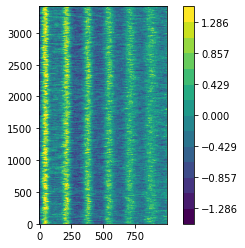

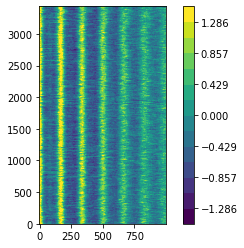

In [44]:
# Call the heat map function to get the heat map of all filtered and positioned data
def get_heat_map(feature_start=8, file_name=r'.\data\genes_arr_pd.csv'):
    save_path = r".\result"
    data_ori = pd.read_csv(file_name)
    data = data_ori.iloc[:, feature_start:]
    cluster = Cluster(data=data, save_path=save_path)
    cluster.normalization()
    cluster.heat_map()
get_heat_map(file_name=r'.\data\genes_arr_pd.csv')
get_heat_map(feature_start=13, file_name=r'.\data\genes_arr_pd_plus_1.csv')

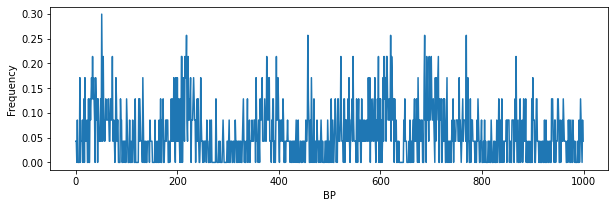

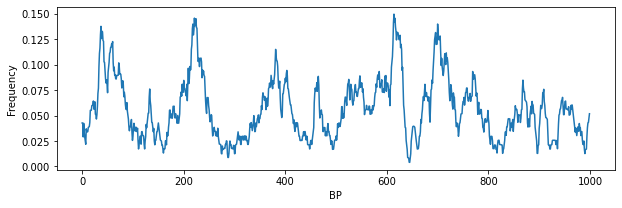

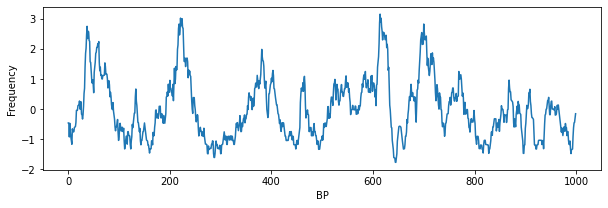

In [4]:
# This function call is for plotting only, plotting raw data, moving average, normalized results for any gene
def get_normalization_results(feature_start=8,
                              file_name=r'.\data\genes_arr_pd.csv'):
    save_path = r".\result"
    data_ori = pd.read_csv(file_name)
    data = data_ori.iloc[:, feature_start:]
    cluster = Cluster(data=data, save_path=save_path)
    cluster.normalization(plot_normalization_result=True)
get_normalization_results()

In [5]:
# This class is used to draw the results of cluster analysis
class ResultAnalysis:
    def __init__(self, result_data, save_path, method):
        """
        Initialize the results of cluster analysis.
        Parameters:
        grouped_genes              : The results of grouping the original data according to the clustering results.
        self.mean_of_grouped_genes : For grouped results, get the mean of each group of data.
        """
        self.result_data = result_data
        self.save_path = save_path
        self.method = method
        grouped_genes = self.result_data.groupby("predict labels")
        self.mean_of_grouped_genes = grouped_genes.agg("mean")
        self.length_gene = 1000

        print(80 * "*")
        self.groups = {}
        for key, item in grouped_genes.groups.items():
            print("{0} : {1}".format(key, len(item)))
            self.groups[key] = len(item)
        print(80 * "*")
    
    def plot_means(self):
        """
        Draw the result graph, draw the mean of different grouping results in one graph.
        """
        font_size = 16
        plt.figure()
        for idx, row in self.mean_of_grouped_genes.iterrows():
            # row = gaussian_filter1d(row, sigma=5)
            plt.plot(range(0, self.length_gene), row, label=str(idx) + "-->" + str(self.groups[idx]))
            plt.legend()

        # plt.title(str(idx))
        plt.xlabel("BP", fontsize=font_size)
        plt.ylabel("Means Normalised Reads", fontsize=font_size)

        plt.savefig(self.save_path + os.path.sep + self.method + "_0729.png",
                    dpi=180,
                    bbox_inches='tight')

In [30]:
"""
This function is used to calculate the most suitable number of classification categories.
Use a loop to cluster using different n_clusters parameters, get the score of each cluster analysis.
"""
def get_kmeans_k(feature_start=8, 
                 file_name=r'.\data\genes_arr_pd.csv',
                 begin=2,
                 end=12):
    """
    Parameters:
    begin: beginning of n_clusters
    end  : ending of n_clusters
    """

    data_ori = pd.read_csv(file_name)
    data = data_ori.iloc[:, feature_start:]

    cluster = Cluster(data)
    cluster.normalization()
    scores = []
    for n_clusters in range(begin, end):
        print("n_clusters: ", n_clusters)
        cluster_method = KMeans(init="k-means++", n_clusters=n_clusters, random_state=0)
        cluster.cluster_fit(method=cluster_method)
        scores.append(cluster.score)

    fontsize = 15
    plt.figure()
    plt.plot(range(begin, end), scores)
    plt.scatter(range(begin, end), scores, c="r")
    plt.xlabel("K", fontsize=fontsize)
    plt.ylabel("Silhouette score", fontsize=fontsize)
    plt.show()
    plt.close()

n_clusters:  2
n_clusters:  3
n_clusters:  4
n_clusters:  5
n_clusters:  6
n_clusters:  7
n_clusters:  8
n_clusters:  9
n_clusters:  10
n_clusters:  11


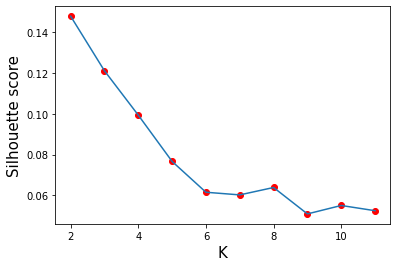

In [31]:
get_kmeans_k(begin=2, end=12)

(3417, 1000)
row number:  0， k-distance:  39.09050082322356
row number:  500， k-distance:  48.40251160756372
row number:  1000， k-distance:  41.0697643865963
row number:  1500， k-distance:  41.889023877262346
row number:  2000， k-distance:  45.42341293278915
row number:  2500， k-distance:  37.3728651046082
row number:  3000， k-distance:  43.46367495502379


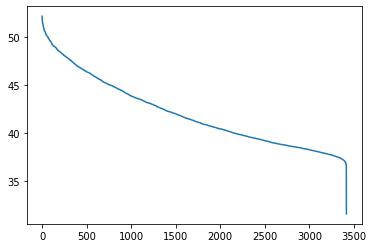

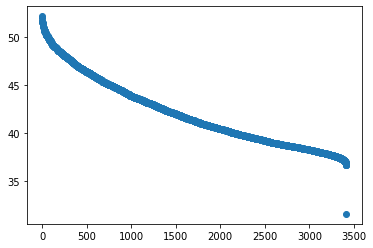

In [40]:
# Call the get DBSCAN eps parameter function to get the k-distance distribution map
def run_get_dbscan_eps(feature_start=8,
                       file_name=r'.\data\genes_arr_pd.csv'):
    save_path = r".\result"
    data_ori = pd.read_csv(file_name)
    data = data_ori.iloc[:, feature_start:]

    cluster = Cluster(data=data, save_path=save_path)
    cluster.normalization()
    cluster.get_dbscan_eps()
run_get_dbscan_eps()

In [7]:
"""
This is a complex grid search function, the purpose is to search the eps and minimum
samples of the DBSCAN method within a certain range. Finally, a scatter plot is drawn,
and the size of the point represents the model performance evaluation result.
"""
def dbscan_eps_and_min_samples(feature_start=8,
                               file_name=r'.\data\genes_arr_pd.csv'):
    save_path = r".\result"
    data_ori = pd.read_csv(file_name)
    data = data_ori.iloc[:, feature_start:]

    cluster = Cluster(data=data, save_path=save_path)
    cluster.normalization()
    # cluster.get_dbscan_eps()

    eps_begin = 28
    eps_end = 32
    mim_samples_begin = 98
    min_samples_end = 120
    eps = np.arange(eps_begin, eps_end, 1)
    min_samples = np.arange(mim_samples_begin, min_samples_end, 2)
    """
    Pre-initialize the results, if all parameters do not meet the model running conditions,
    the results are not empty, the drawing part of the code can still run, the code will not crash
    """
    results = [[0 for _ in range(5)]]
    
    """
    Note: Note that not all parameters meet the running requirements of DBSCAN. If the group is
    not satisfied, the data at this point will be blank, so I use the try-except statement in Python.
    This statement will not interrupt the function when DBSCAN cannot be executed
    """
    for i in eps:
        for j in min_samples:
            try:
                cluster_method = DBSCAN(eps=i, min_samples=j)
                predict_labels = cluster.cluster_fit(method=cluster_method)
                score = metrics.silhouette_score(data, predict_labels) 
                raito = len(predict_labels[predict_labels[:] == -1]) / len(predict_labels)
                n_clusters = len(set(predict_labels)) - (1 if -1 in predict_labels else 0)
                results.append([i, j, score, raito, n_clusters])
#                 print("gird: ", [i, j, score, raito, n_clusters])
            except:
                continue
    results = pd.DataFrame(results)
    results.columns = ['eps', 'min_samples', 'score', 'raito', 'n_clusters']

    sns.relplot(x="eps", y="min_samples", size='score', data=results, hue="n_clusters")
    plt.xlim([23, 35])
    plt.ylim([93, 106])
    plt.show()
    sns.relplot(x="eps", y="min_samples", size='raito', data=results, hue="n_clusters")
    plt.xlim([23, 35])
    plt.ylim([93, 106])
    plt.show()


In [8]:
"""
This is a python decorator, which is a dispensable function, 
I mainly use it to calculate the running time of the clustering 
function. To use this function, just add @dev in front of the 
defined function, for example: 

@dev
def run_dbscan_eps_and_min_samples():
    pass
    
"""

def dev(fun):
    @wraps(fun)
    def wrap_the_function():
        start = time.time()
        fun()
        end = time.time()
        time_run = (end - start)/60
        print("-----------------------------------")
        print("time: ", time_run, "min")
        print("-----------------------------------")
    return wrap_the_function


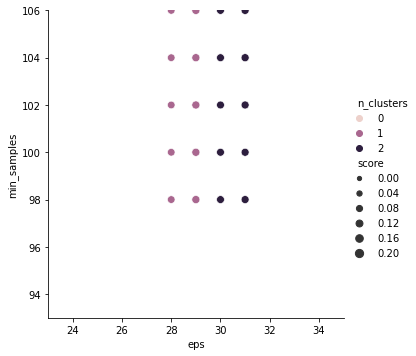

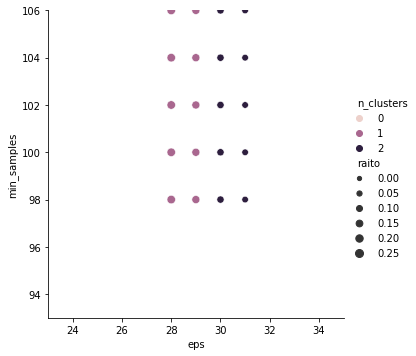

-----------------------------------
time:  1.646300729115804 min
-----------------------------------


In [10]:
# dbscan_eps_and_min_samples function call
@dev
def run_dbscan_eps_and_min_samples():
    dbscan_eps_and_min_samples(feature_start=8, file_name=r'.\data\genes_arr_pd.csv')
run_dbscan_eps_and_min_samples()

In [16]:
"""
This function is a function of cluster analysis, and two methods of k-means++ and DBSCAN can be used.
You can set the number of categorical groups for the k-means method by setting n_clusters.
"""

def run_cluster(cluster_method="k-mean++", feature_start=8, file_name=r'.\data\genes_arr_pd.csv', n_clusters=3):
    save_path = r".\result"
    data_ori = pd.read_csv(file_name)
    data = data_ori.iloc[:, feature_start:]

    cluster = Cluster(data)
    cluster.normalization()
    (n_samples, n_features) = data.shape

    print(f"# digits: {n_clusters}; # samples: {n_samples}; # features {n_features}")
    print(82 * "_")
    cluster_methods = {
        "k-means++": KMeans(init="k-means++", n_clusters=n_clusters, random_state=0),
        "DBSCAN": DBSCAN(eps=30, min_samples=100)
    }
    predict_labels = cluster.cluster_fit(method=cluster_methods[cluster_method])
    print("Silhouette score: ", cluster.score)

    method = cluster_method + str(n_clusters)

    data["predict labels"] = predict_labels
    predict_labels_data = data_ori.iloc[:, :feature_start + 1]
    predict_labels_data["predict labels"] = predict_labels
    
    # # Store the results of the clustering
    # predict_labels_data.to_csv(save_path + os.path.sep + cluster_method + "_predict_result.csv", index=None)
    
    # Instantiate a result analysis class for clustering result analysis
    result_analysis = ResultAnalysis(data, save_path, method)
    result_analysis.plot_means()

    print(82 * "_")


# digits: 3; # samples: 3417; # features 1000
__________________________________________________________________________________
Silhouette score:  0.12112233918451712
********************************************************************************
0 : 1332
1 : 1303
2 : 782
********************************************************************************
__________________________________________________________________________________
# digits: 4; # samples: 3417; # features 1000
__________________________________________________________________________________
Silhouette score:  0.09935008009206037
********************************************************************************
0 : 589
1 : 1229
2 : 681
3 : 918
********************************************************************************
__________________________________________________________________________________


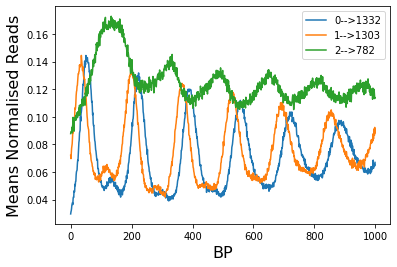

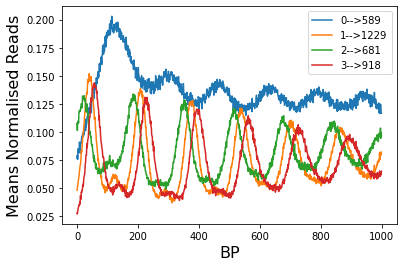

In [19]:
# Call the k-means method and set different n_clusters
run_cluster(cluster_method="k-means++",
            feature_start=8,
            file_name=r'.\data\genes_arr_pd.csv',
            n_clusters=3)

run_cluster(cluster_method="k-means++",
            feature_start=8,
            file_name=r'.\data\genes_arr_pd.csv',
            n_clusters=4)

# digits: 5; # samples: 3417; # features 1000
__________________________________________________________________________________
Silhouette score:  0.07663103888390906
********************************************************************************
0 : 483
1 : 518
2 : 825
3 : 968
4 : 623
********************************************************************************
__________________________________________________________________________________
# digits: 6; # samples: 3417; # features 1000
__________________________________________________________________________________
Silhouette score:  0.061511976996644006
********************************************************************************
0 : 831
1 : 717
2 : 462
3 : 639
4 : 456
5 : 312
********************************************************************************
__________________________________________________________________________________


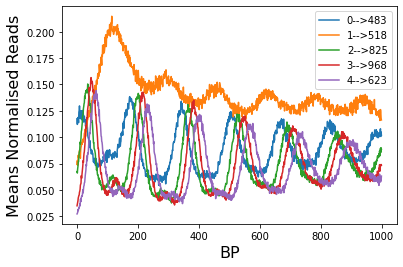

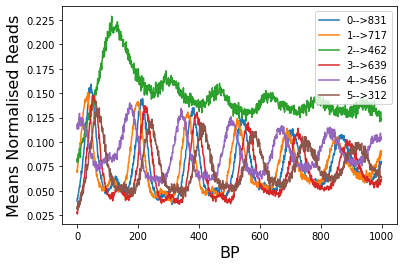

In [18]:
# Call the k-means method and set different n_clusters
run_cluster(cluster_method="k-means++",
            feature_start=8,
            file_name=r'.\data\genes_arr_pd.csv',
            n_clusters=5)

run_cluster(cluster_method="k-means++",
            feature_start=8,
            file_name=r'.\data\genes_arr_pd.csv',
            n_clusters=6)

# digits: 0; # samples: 3417; # features 1000
__________________________________________________________________________________
Silhouette score:  0.12189609995471878
********************************************************************************
-1 : 631
0 : 2685
1 : 101
********************************************************************************
__________________________________________________________________________________


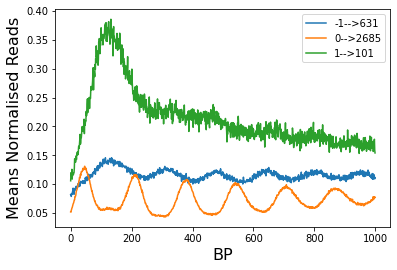

In [21]:
# Call the DBSCAN method
run_cluster(cluster_method="DBSCAN",
            feature_start=8,
            file_name=r'.\data\genes_arr_pd.csv',
            n_clusters=0)

# digits: 3; # samples: 3435; # features 1000
__________________________________________________________________________________
Silhouette score:  0.08511019407972446
********************************************************************************
0 : 1314
1 : 1495
2 : 626
********************************************************************************
__________________________________________________________________________________


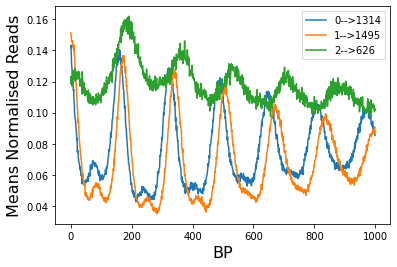

In [22]:
# Call k-means method, using +1 nucleosome data, n_clusters=3
run_cluster(cluster_method="k-means++",
            feature_start=13,
            file_name=r'.\data\genes_arr_pd_plus_1.csv',
            n_clusters=3)

# digits: 4; # samples: 3435; # features 1000
__________________________________________________________________________________
Silhouette score:  0.06377989545632727
********************************************************************************
0 : 638
1 : 970
2 : 1336
3 : 491
********************************************************************************
__________________________________________________________________________________


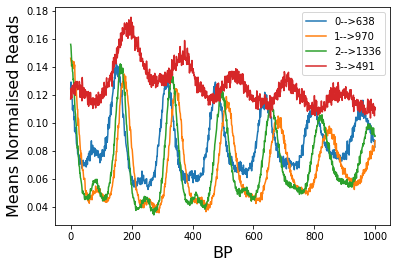

In [23]:
# Call k-means method, using +1 nucleosome data, n_clusters=4
run_cluster(cluster_method="k-means++",
            feature_start=13,
            file_name=r'.\data\genes_arr_pd_plus_1.csv',
            n_clusters=4)

# digits: 5; # samples: 3435; # features 1000
__________________________________________________________________________________
Silhouette score:  0.06355750530751432
********************************************************************************
0 : 1268
1 : 913
2 : 620
3 : 343
4 : 291
********************************************************************************
__________________________________________________________________________________


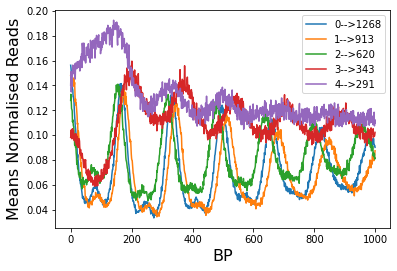

In [24]:
# Call k-means method, using +1 nucleosome data, n_clusters=5
run_cluster(cluster_method="k-means++",
            feature_start=13,
            file_name=r'.\data\genes_arr_pd_plus_1.csv',
            n_clusters=5)

# digits: 6; # samples: 3435; # features 1000
__________________________________________________________________________________
Silhouette score:  0.05538817772289026
********************************************************************************
0 : 524
1 : 952
2 : 209
3 : 1100
4 : 269
5 : 381
********************************************************************************
__________________________________________________________________________________


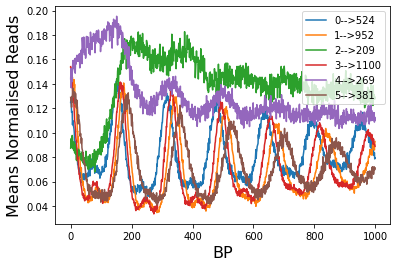

In [25]:
# Call k-means method, using +1 nucleosome data, n_clusters=6
run_cluster(cluster_method="k-means++",
            feature_start=13,
            file_name=r'.\data\genes_arr_pd_plus_1.csv',
            n_clusters=6)